In [ ]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

In [2]:
air_data = pd.read_csv('AirPassengers.csv')

In [3]:
air_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


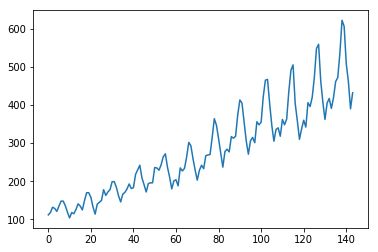

In [4]:
plt.plot(air_data.iloc[:,1])

In [ ]:
#Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
air_data_scale = scaler.fit_transform(air_data.iloc[:,1:])

In [6]:
air_data_scale[1:15]

array([[0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853],
       [0.05984556],
       [0.08494208],
       [0.08494208],
       [0.06177606],
       [0.02895753],
       [0.        ],
       [0.02702703],
       [0.02123552],
       [0.04247104],
       [0.07142857]])

In [7]:
train_data, test_data = np.split(air_data_scale, [int(.80*len(air_data_scale))])

In [8]:
# convert an array of values into a dataset matrix
def time_step_data(dataset, time_step_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step_back - 1):
        a = dataset[i:(i + time_step_back), 0]   ###i=0, 0,1,2,3
        dataX.append(a)
        dataY.append(dataset[i + time_step_back, 0])
        
    return np.array(dataX), np.array(dataY)

In [9]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step_back = 4
X_train, y_train = time_step_data(train_data, time_step_back)
X_test, y_test = time_step_data(test_data, time_step_back)

In [10]:
# reshape input to be [samples, time steps, features]
train_X = X_train.reshape(X_train.shape[0], 4, 1)
test_X = X_test.reshape(X_test.shape[0], 4, 1)

In [11]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(GRU(units=30, return_sequences=True))
model.add(GRU(units=30))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4, 50)             7800      
_________________________________________________________________
gru_2 (GRU)                  (None, 4, 30)             7290      
_________________________________________________________________
gru_3 (GRU)                  (None, 30)                5490      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 20,611
Trainable params: 20,611
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit gru
model.fit(train_X, y_train, epochs=50, batch_size=3, validation_data=(test_X, y_test), verbose=1)

Train on 110 samples, validate on 24 samples
Epoch 1/50
110/110 [==============================] - 3s 29ms/step - loss: 0.0263 - val_loss: 0.0439
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0307
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0346
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0320
Epoch 5/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0288
Epoch 6/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0271
Epoch 7/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0260
Epoch 8/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0251
Epoch 9/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0304
Epoch 10/50
110/110 [==============================] -

In [13]:
# Estimate model performance
trainScore = model.evaluate(train_X, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))

testScore = model.evaluate(test_X, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore))) 

110/110 [==============================] - 0s 364us/step
Train Score: 0.00 MSE (0.05 RMSE)
24/24 [==============================] - 0s 104us/step
Test Score: 0.02 MSE (0.13 RMSE)


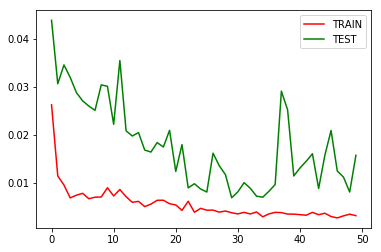

In [14]:
# plot the loss
plt.plot(model.history.history['loss'], label='TRAIN', color='red')
plt.plot(model.history.history['val_loss'], label='TEST', color='green')
plt.legend()
plt.show()

In [15]:
#train and test prediction
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

In [16]:
#invert predictions, transform back to original format
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [17]:
#Calculate performance metric - RMSE 
math.sqrt(mean_squared_error(y_train, train_predict))
#264.46261189104933

248.86838975308677

In [18]:
math.sqrt(mean_squared_error(y_test, test_predict))
#434.4435737357026

406.79551395910886

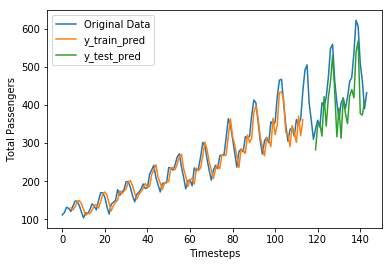

In [19]:
# Plotting 
# shift train predictions for plotting
look_back=4
trainPredictPlot = np.empty_like(air_data_scale)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(air_data_scale)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(air_data_scale)-1, :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(air_data_scale), label='Original Data')
plt.plot(trainPredictPlot ,label='y_train_pred')
plt.plot(testPredictPlot ,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()